# TP 2 - Part 2 

**The story!**
You are a data scientist working for the hotel, one day the manager comes and tells you.

In our hotels we have an option to offer a parking spot, which costs money. Apparently, not every customer is aware that we have such an option. I really want to offer parking spots for everyone who needs it, because the hotel can earn more money like that. Look, I can send an SMS notification to our customers. Of course SMS are not free, and, moreover, people get very much angry if they receive stupid notifications for no reason. For each new reservation, I would like to decide if I should or shouldn't send the notification to the customer.

**Problem** Explore your data to help the manager and construct a prediction algorithm, using the above template as an inspiration. 

**Warning!** Be aware, that some columns are not actually avaiable at the moment of reservation. For instance, the target column ```is_canceled``` from the previous part clearly cannot be observed at the moment when we need to decide to send the SMS.

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [4]:
data = pd.read_csv("Data/bookings.csv") 

In [5]:
data.head(5) 

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


---

## Exploratory Data Analysis

In [8]:
# Columns describtion
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


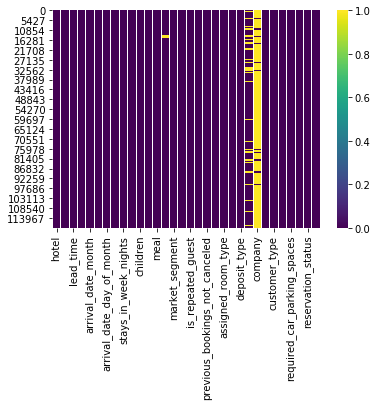

In [9]:
# Missing Values
sns.heatmap(data.isna(),cmap='viridis')

In [10]:
data_resort = data[data['hotel']=='Resort Hotel']

data_resort.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Checking the distributuon of 'parking wanting' customers
* Children 
* Length of stay ( use regplot)
* Booking per market segment


#### Having kids impact on parking

In [11]:
data['required_car_parking_spaces']= data['required_car_parking_spaces'].apply(lambda x : 1 if x>0 else 0 )

data['required_car_parking_spaces'].value_counts()/len(data['required_car_parking_spaces'])

0    0.937884
1    0.062116
Name: required_car_parking_spaces, dtype: float64


> We have an imbalanced dataset

In [12]:
data_resort['has_kids']=data_resort['babies']+data_resort['children']
data_resort['has_kids']= data_resort['has_kids'].apply(lambda x : 1 if x>0 else 0 )

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[]

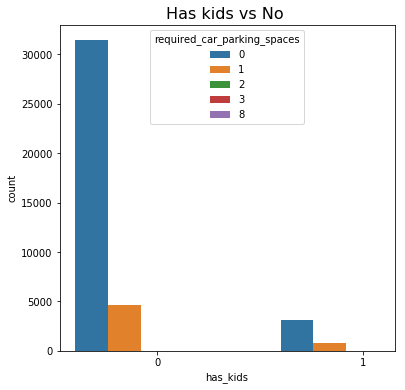

In [13]:
plt.figure(figsize=(6, 6))
sns.countplot(x="has_kids", hue="required_car_parking_spaces", data=data_resort)
plt.title("Has kids vs No ", fontsize=16)
plt.plot()

#### How country impact parking space

In [14]:
need_parking_country= data_resort.groupby('country')['required_car_parking_spaces'].sum().sort_values(ascending=False)

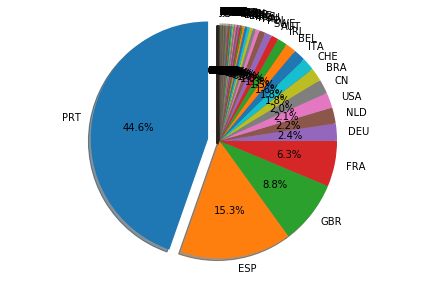

In [15]:
labels = need_parking_country.keys()
number = need_parking_country.array
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = [0.1]+[ 0 for i in range(len(number)-1)]  
fig1, ax1 = plt.subplots()
ax1.pie(number, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

> We clearly see that most country reservation are made in portugal

Let's divide it by number of reservations first

In [18]:
data_by_country=data.groupby('country')['required_car_parking_spaces'].agg(['sum','count'])

data_by_country['percentage_required']=data_by_country['sum'] / data_by_country['count']

In [19]:
data_by_country[data_by_country['count']>data_by_country['count'].median()].sort_values(by='percentage_required',ascending= False).head()

,sum,count,percentage_required
country,,,
OMN,3,18,0.166667
URY,5,32,0.156250
ESP,1191,8568,0.139006
ARG,29,214,0.135514
KWT,2,16,0.125000


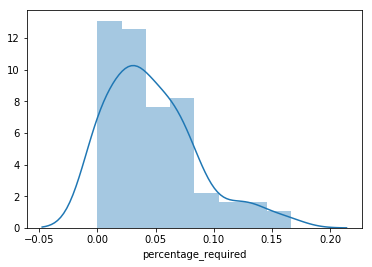

In [20]:
dummy =data_by_country[data_by_country['count']>data_by_country['count'].median()]['percentage_required']
sns.distplot(dummy)

> No clear relation between reservations from countries and parking resrvations

---

## Preparing Data

### Adding Features

In [5]:
df = data.copy()

def family(data):
    if ((data['adults'] > 0) & (data['children'] > 0)) or ((data['adults'] > 0) & (data['babies'] > 0)) :
        val = 1
    else:
        val = 0
    return val

    
def feature(data):
    data["is_family"] = data.apply(family, axis = 1)
    data["total_customer"] = data["adults"] + data["children"] + data["babies"]
    data["total_nights"] = data["stays_in_weekend_nights"]+ data["stays_in_week_nights"]
    return data

df = feature(df)
df = df.drop(columns = ['company','adults', 'babies', 'children', 'deposit_type', 'reservation_status_date','is_canceled'])

df.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,country,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,is_family,total_customer,total_nights
0,Resort Hotel,342,2015,July,27,1,0,0,BB,PRT,...,NaN,0,Transient,0.0,0,0,Check-Out,0,2.0,0
1,Resort Hotel,737,2015,July,27,1,0,0,BB,PRT,...,NaN,0,Transient,0.0,0,0,Check-Out,0,2.0,0
2,Resort Hotel,7,2015,July,27,1,0,1,BB,GBR,...,NaN,0,Transient,75.0,0,0,Check-Out,0,1.0,1
3,Resort Hotel,13,2015,July,27,1,0,1,BB,GBR,...,304.0,0,Transient,75.0,0,0,Check-Out,0,1.0,1
4,Resort Hotel,14,2015,July,27,1,0,2,BB,GBR,...,240.0,0,Transient,98.0,0,1,Check-Out,0,2.0,2


### Transforming data

In [6]:
categorical_features = list(df.dtypes.where(df.dtypes== object).dropna().index)
numeric_features =  list(df.dtypes.where(df.dtypes != object).dropna().index)
numeric_features.remove('required_car_parking_spaces')
features = numeric_features + categorical_features

X = df[features]
y= df['required_car_parking_spaces'].apply(lambda x : 1 if x>0 else 0 )

In [7]:
numeric_transformer = Pipeline(steps =[('scaler',StandardScaler()),('imputer',SimpleImputer(strategy="constant", fill_value=0))])
categorical_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value="Not defined")),
                                    ("onehot", OneHotEncoder(handle_unknown='ignore'))]) # to deal with missing categorical data 
preproc = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                          ("cat", categorical_transformer, categorical_features)])

In [8]:
print('Training on X  shape : ',X.shape)
print('Training on y  shape : ',y.shape)

Training on X  shape :  (119390, 27)
Training on y  shape :  (119390,)


In [9]:
X_t = preproc.fit_transform(X).toarray()
print('Training on X  shape : ',X_t.shape)
print('Training on y  shape : ',y.shape)

Training on X  shape :  (119390, 256)
Training on y  shape :  (119390,)


---

## Visualizing in latent space

Let's visualize the distribution of the parking vs no-parking reservations?.

In [26]:
from sklearn.decomposition import TruncatedSVD

In [27]:
X_r =  TruncatedSVD(n_components=2).fit_transform(X_t)

Text(0.5, 1.0, 'Truncated SVD of representation dataset')

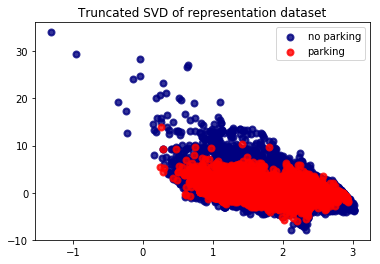

In [28]:
colors = ['navy', 'red']
lw = 2
target_names =['no parking','parking']
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    plt.savefig('TruncatedSVD.png')

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Truncated SVD of representation dataset')

> There is no apparent clear separation between the 'NP' and 'P' reservations. 

---

## Training

### Step 1. Choosing Metric

**Recall- Precision**
We want to create a balanced classification model with the optimal balance of recall and precision.

We want to identify the maximum number of indivials who will probably need a parking space ( recall) whilst being correct with a high probability(precision). 

*The positive class is more important in our case, a variation of the F-Measure can be used to optimize the precision and recall. If false negatives are more costly, then the F2-Measure can be used, otherwise, if false positives are more costly, then the F0.5-Measure can be used.*

The metric we will use is the F0.5 score. where $F_\beta$ 

$F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}$

> β is chosen such that recall is considered β times as important as precision

### Step 2. Defining Framework to deal with the imbalanced classes problem

Spot checking machine learning algorithms means evaluating a suite of different types of algorithms with minimal hyperparameter tuning

We will train these algorithms :

**A. Spot-Checking Machine Learning Algorithms**
1. Naive Algorithms : naive classification must be evaluated.
This provides a rock-bottom baseline in performance that any algorithm must overcome in order to have skill on the dataset.  => We used the DummyClassifier
    
2. Linear Algorithms => Logistic Regression
3. Nonlinear Algorithms => Support Vector Machine
4. Ensemble Algorithms => Random Forest , Stochastic Gradient Boosting


**B. Spot-Checking Machine Learning Algorithms**
1. Data Oversampling : Random Oversampling , SMOTE
2. Data Undersampling : Random Undersampling, Condensed Nearest Neighbor
3. Combine Oversampling and undersampling
4. Cost sensitive algorithms

#### A. Spot checking machine Learning Algorithms

In [10]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score
f5_scorer = make_scorer(fbeta_score, beta=0.5)

We ran these untuned models on a Google Cloud Platform 
```python
ml_models =[('dummy_stratified',DummyClassifier()),
            ('dummy_prior',DummyClassifier(strategy='prior'))
             ('logistic_reg',LogisticRegression(n_jobs=-1)),
            ('knn',KNeighborsClassifier(n_jobs=-1)),
           ('svm',SVC()),
           ('random_forest',RandomForestClassifier(n_jobs=-1)),
           ('xgboost',),
           ('neural_network',)]

model_score ={}

for name, model in ml_models:
    scores = cross_val_score(model, X_t, y[:1000], scoring=f5_scorer, cv=10, n_jobs=-1)
    model_score[name] = {'score' :scores, 'mean_score':np.mean(scores),'std_score': np.std(scores)}
```

#### Result

We ran the *bare models* to estimate the score and choose the class of model that gives the best F0.5 score as is. We will then perform hyperparameter tuning

In [123]:
res =pd.read_csv('spot_check_result.csv',index_col=0)
res2  =pd.read_csv('spot_check_result2.csv',index_col=0)
res =pd.concat([res, res2], axis=1)


res = res.drop('score')
res =res.astype('float')

Text(0, 0.5, 'F0.5 Score')

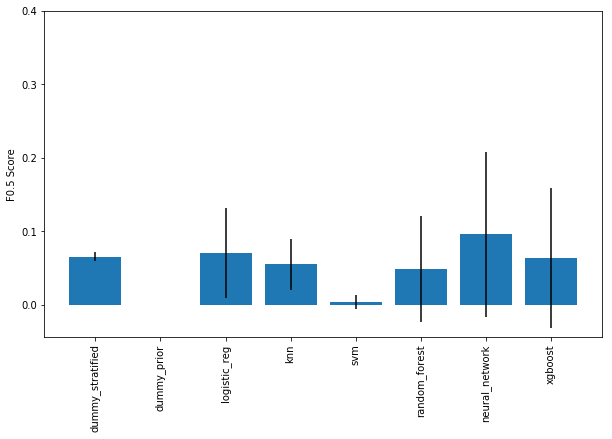

In [124]:
ind = np.arange(res.loc['mean_score'].shape[0])
plt.figure(figsize=(10, 6))

plt.bar(ind,height=res.loc['mean_score'].values,yerr=res.loc['std_score'])
plt.xticks(ind, list(res.columns),rotation='vertical')
plt.yticks(np.arange(0, 0.5, 0.1))
plt.ylabel('F0.5 Score')


> We see that the best F0.5 scoring classifiers are the logistic regression and the Random Forest. This is still avery low F score.
We will need to check if using Imbalanced Machine learning Algorithms helps the performance 

#### B. Spot checking Imbalanced Algorithms

**Smote Oversampling**

One way to solve this problem is to oversample the examples in the minority class, the most widely used approach to synthesizing new examples is called the **Synthetic Minority Oversampling TEchnique, or SMOTE for short.** [[paper link]](https://arxiv.org/abs/1106.1813)

 We combine SMOTE and Random Undersampling to achieve a ratio of 1:2

We will need to install fo this step : 
```python
!pip install imbalanced-learn
````

We then ran this on our GCP machine :

```python
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import CounterM

# Testing on best performing algorithms acording to our metric in step 1  , Random Forest , NN , XGboost

over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
ml_models3 =[('logistic_reg',LogisticRegression(n_jobs=-1)),('neural_network',MLPClassifier()),('xgboost',XGBClassifier(n_jobs=-1))]


model_score ={}

for name, model in ml_models3:
    imba_pipeline = Pipeline(steps=[('over', over), ('under', under),(name,model)])
    scores = cross_val_score(imba_pipeline, X_t,y, scoring=f5_scorer, cv=10, n_jobs=-1)
    model_score[name] = {'score' :scores, 'mean_score':np.mean(scores),'std_score': np.std(scores)}
````

#### Result

In [117]:
res =pd.read_csv('spot_check_unbalanced.csv',index_col=0)
res = res.drop('score')
res =res.astype('float')

Text(0, 0.5, 'F0.5 Score')

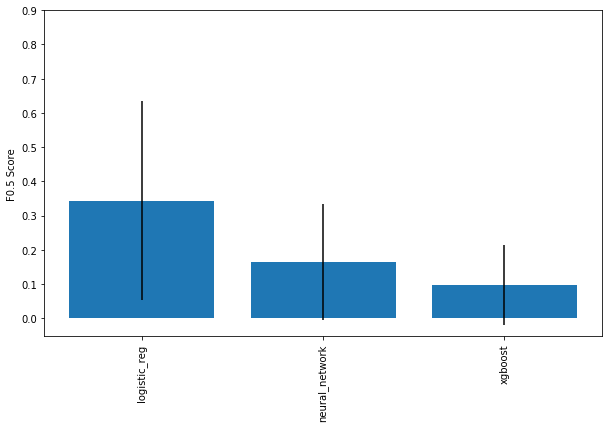

In [121]:
ind = np.arange(res.loc['mean_score'].shape[0])
plt.figure(figsize=(10, 6))

plt.bar(ind,height=res.loc['mean_score'].values,yerr=res.loc['std_score'])
plt.xticks(ind, list(res.columns),rotation='vertical')
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel('F0.5 Score')


>  Very suprising ! Might check if everything is working

**Cost senstive algorithms**

One way to solve this problem is to oversample the examples in the minority class, the most widely used approach to synthesizing new examples is called the **Synthetic Minority Oversampling TEchnique, or SMOTE for short.** [[paper link]](https://arxiv.org/abs/1106.1813)

 We combine SMOTE and Random Undersampling to achieve a ratio of 1:2

We will need to install fo this step : 
```python
!pip install imbalanced-learn
````

---

### Step 3. Hyperparameter Tuning

Now that we have chosen our machine learning algorithm we need to tune the parameters

```python
models = [("logreg_with_scale", LogisticRegression(max_iter=1000)),("svc",SVC()),("random_forest", RandomForestClassifier())]

#models = [("logreg_with_scale", LogisticRegression(max_iter=10000))]

#models = [("svc",SVC())]

grids = {"logreg_with_scale" : {'logreg_with_scale__C': np.logspace(-2, 2, 5, base=2)}, 
         "svc" :{'svc__gamma':np.logspace(-4, 1, 10)},
         "random_forest" : {'random_forest__n_estimators': [500,600,800]}}

# cast int to float to avoid Standard scaler error :

X[numeric_features] = X[numeric_features].astype(float)

for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3,n_jobs=-1)
    clf.fit(X, y)
    print('Results for {}'.format(name))
    #print(clf.cv_results_)
    print("Mean test score :", clf.cv_results_['mean_test_score'])
````

#### Retriving Models trained on GCP

In [ ]:
# load the model from disk
RF_path ='Models/random_forest_model.pkl'
LR_path ='Models/logreg_with_scale_model.pkl'

RF_model = pickle.load(open(RF_path, 'rb'))

In [ ]:
RF_model.cv_results_['mean_test_score']

---

## Analysing results

> Accuracy is not a good measure for assessing model performance.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

#### Plotting Confusion matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

y_pred = RF_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

print("Classification report for classifier :\n%s\n"
      % (classification_report(y_test, y_pred)))

In [ ]:
## Comparing to Dummy classfier
model = DummyClassifier(strategy='most_frequent') # generates predictions by respecting the training set’s class distribution.
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

print("Classification report for classifier :\n%s\n"
      % (classification_report(y_test, y_pred)))

#### Plotting ROC Curve

> ROC analysis does not have any bias toward models that perform well on the minority class at the expense of the majority class—a property that is quite attractive when dealing with imbalanced data

AUCROC can be interpreted as the probability that the scores given by a classifier will rank a 
randomly chosen positive instance higher than a randomly chosen negative one

This single score can be used to compare binary classifier models directly. As such, this score might be the most commonly used for comparing classification models for imbalanced problems.

### Plotting Precision Recall Curve

In [ ]:
disp = plot_precision_recall_curve(RF_model, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))